In [2]:
import pandas as pd
import sqlite3
import sys
sys.path.append("..")
import seaborn as sns
color_pal = sns.color_palette()
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import yaml

In [16]:
with open("../data/preprocess/fpl2fbref_team_mapping.yml", "r") as file:
    color_map = yaml.safe_load(file)

with sqlite3.connect('../data/fpl.db') as con:
    processed_data = pd.read_sql_query('select * from processed_data where season >= "2017-2018"', con)
processed_data["type"] = processed_data["pos"].map({
    "FW": "att",
    "CM": "att",
    "DM": "att",
    "RW": "att",
    "LW": "att",
    "AM": "att",
    "LM": "att",
    "RM": "att",
    "CB": "def",
    "GK": "def",
    "LB": "def",
    "RB": "def",
    "WB": "def",
})
processed_data.head()

,index,season,fpl_name,round,date,player,venue,team,opponent,start,...,home_total_att_elo_ma5,away_total_att_elo_ma5,total_def_elo_ma5,home_total_def_elo_ma5,away_total_def_elo_ma5,match_points_ma5,league_points_ma5,fpl_points,cached,type
0,10480,2017-2018,Mesut Özil,1.0,2017-08-11 00:00:00.000000,Mesut Özil,Home,Arsenal,Leicester City,1.0,...,2.270609,2.111907,0.500315,0.829387,2.023560,3.0,2.4,2.0,1,att
1,10481,2017-2018,Mohamed Elneny,1.0,2017-08-11 00:00:00.000000,Mohamed Elneny,Home,Arsenal,Leicester City,1.0,...,2.936099,2.622832,1.030028,1.712015,1.865381,1.8,1.4,5.0,1,att
2,10482,2017-2018,Nacho Monreal,1.0,2017-08-11 00:00:00.000000,Nacho Monreal,Home,Arsenal,Leicester City,1.0,...,2.270609,2.111907,0.500315,0.829387,2.023560,3.0,2.4,1.0,1,def
3,10483,2017-2018,Olivier Giroud,1.0,2017-08-11 00:00:00.000000,Olivier Giroud,Home,Arsenal,Leicester City,0.0,...,2.110348,1.995522,0.729568,1.073026,2.135489,2.4,2.4,5.0,1,att
4,10484,2017-2018,Petr Cech,1.0,2017-08-11 00:00:00.000000,Petr Čech,Home,Arsenal,Leicester City,1.0,...,2.270609,2.111907,0.500315,0.829387,2.023560,3.0,2.4,1.0,1,def


## EDA

In [12]:
def jitter_points(values,j):
    return values + np.random.normal(0,j,values.shape)

def plot_scatter(df, x_cols, y_col, color_by=None, jitter=0):
    fig, axes = plt.subplots(nrows=1, ncols=len(x_cols), figsize=(20, 5), sharey=True)
    df_with_jitter = df.copy()
    for col in x_cols:
        df_with_jitter[col] = jitter_points(df_with_jitter[col], j=jitter)
    df_with_jitter[y_col] = jitter_points(df_with_jitter[y_col], j=jitter)
    for ax, x in zip(axes, x_cols):
        sns.scatterplot(x=x, y=y_col, data=df_with_jitter, ax=ax, hue=color_by, alpha=0.75)
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    fig.legend(handles, labels, loc='center right', title=color_by)
    plt.subplots_adjust(right=0.9)
    plt.show()
    
def plot_boxplot(df, x_cols, y_col, bin_width=0.5):
    fig, axes = plt.subplots(nrows=1, ncols=len(x_cols), figsize=(20, 5), sharey=True)
    for ax, x in zip(axes, x_cols):
        copy_df = df[[x, y_col]].copy()
        lower = np.floor(copy_df[x].min()/bin_width)*bin_width
        upper = np.ceil(copy_df[x].max()/bin_width)*bin_width
        bins = np.arange(lower,upper,bin_width)
        copy_df[x] = pd.cut(copy_df[x], bins=bins)
        sns.boxplot(x=x, y=y_col, data=copy_df, ax=ax)
    
    plt.show()

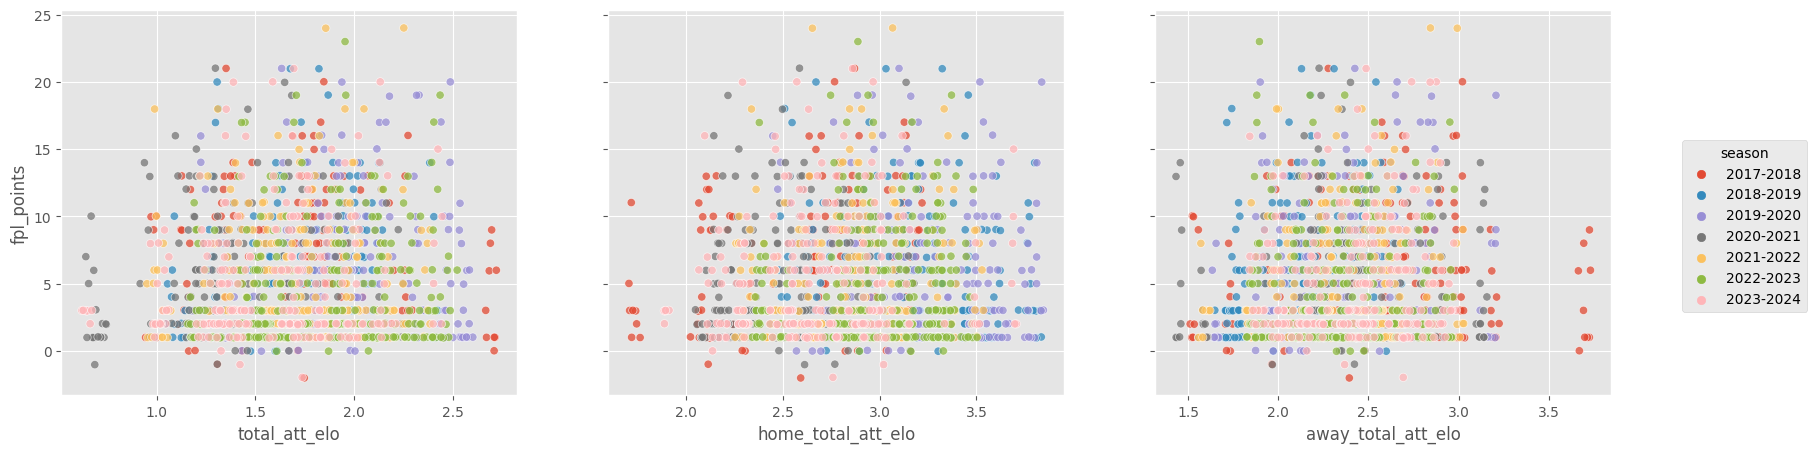

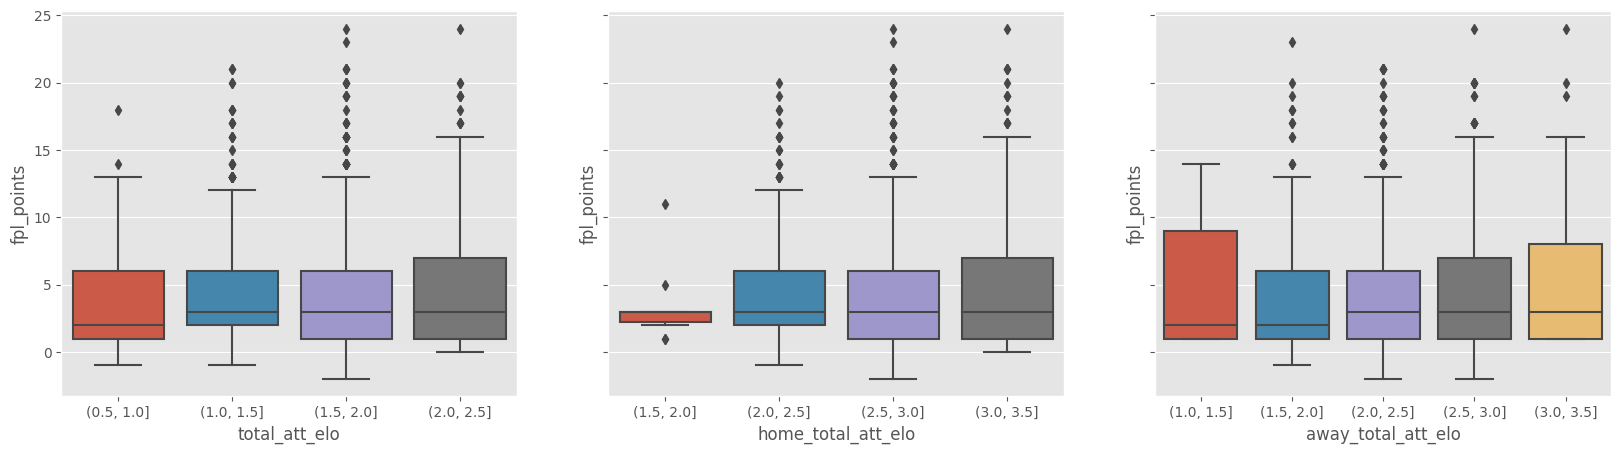

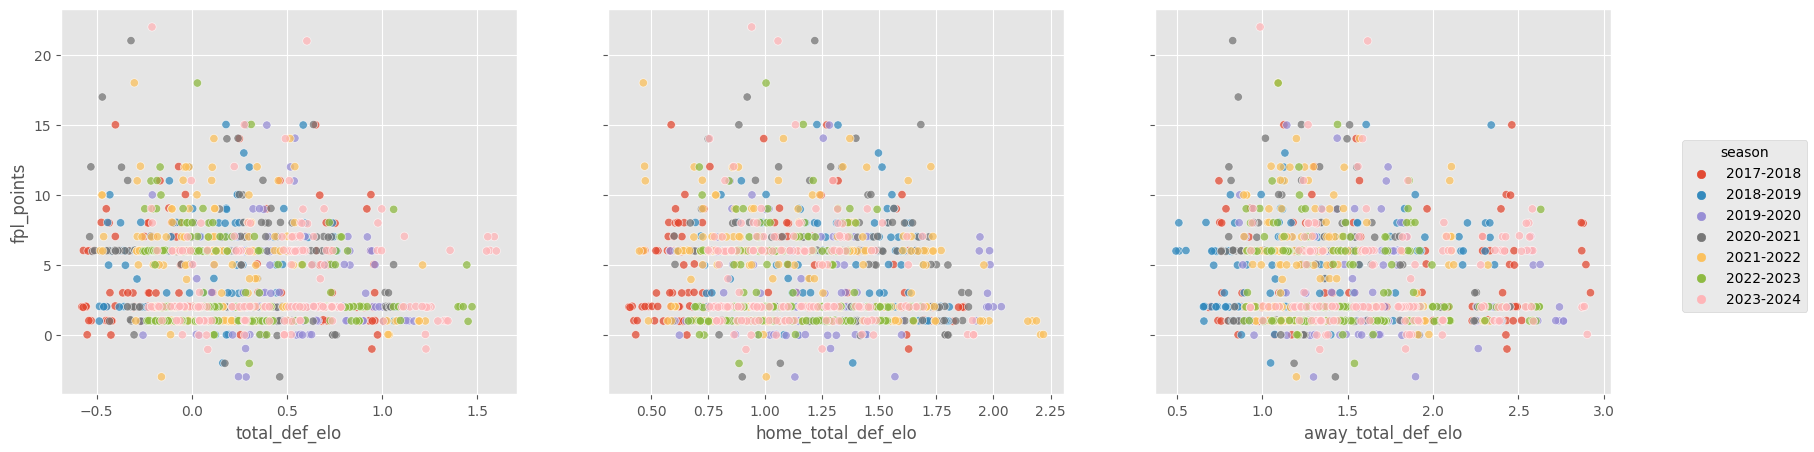

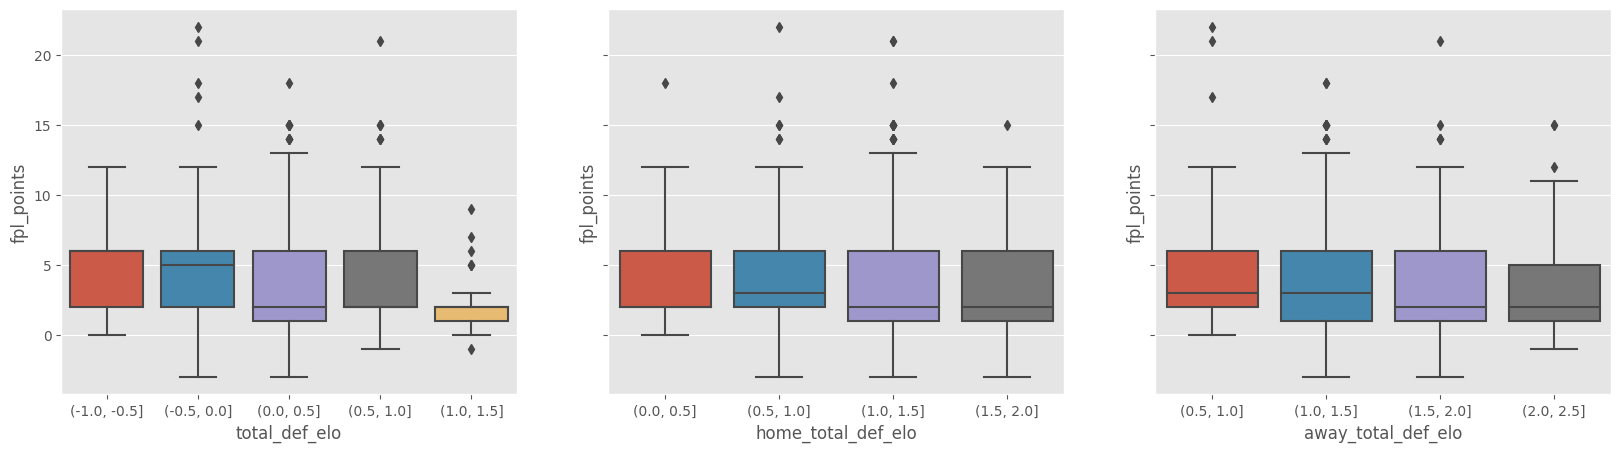

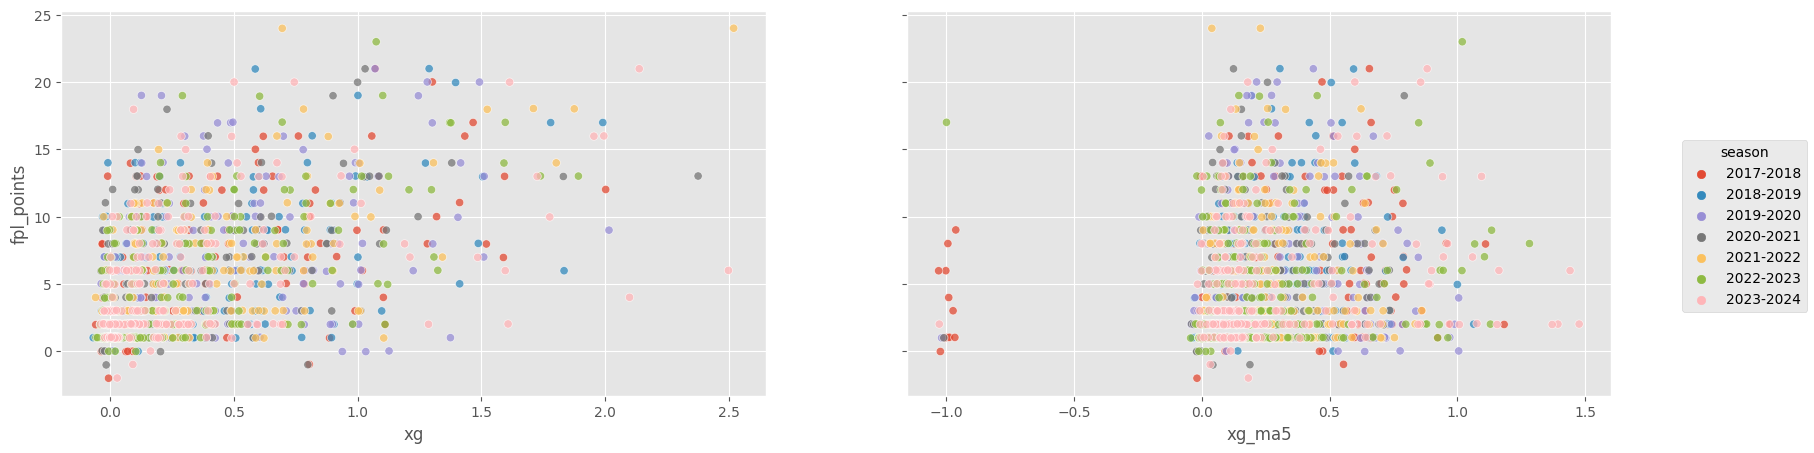

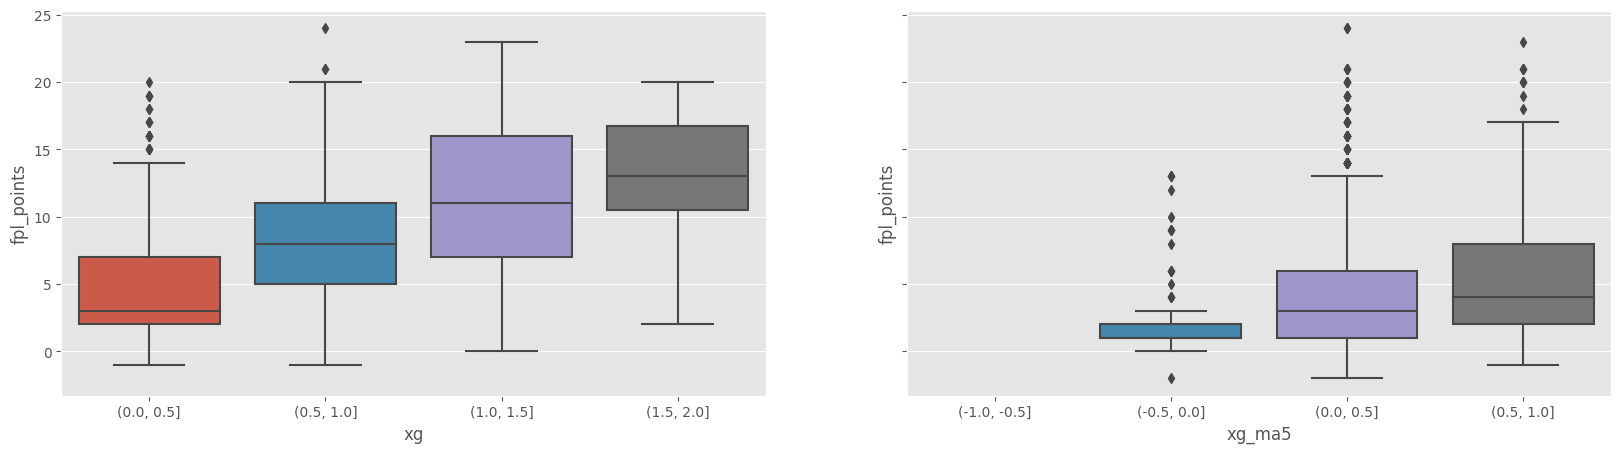

In [18]:
def plot_both(team_df, x_cols):
    plot_scatter(team_df, x_cols, "fpl_points","season",0.02)
    plot_boxplot(team_df, x_cols, "fpl_points")
    
plot_both(processed_data.query("team == 'Manchester City' and type=='att'"), ["total_att_elo", "home_total_att_elo", "away_total_att_elo"])
plot_both(processed_data.query("team == 'Manchester City' and type=='def'"), ["total_def_elo", "home_total_def_elo", "away_total_def_elo"])
plot_both(processed_data.query("team == 'Manchester City' and type=='att'"), ["xg", "xg_ma5"])

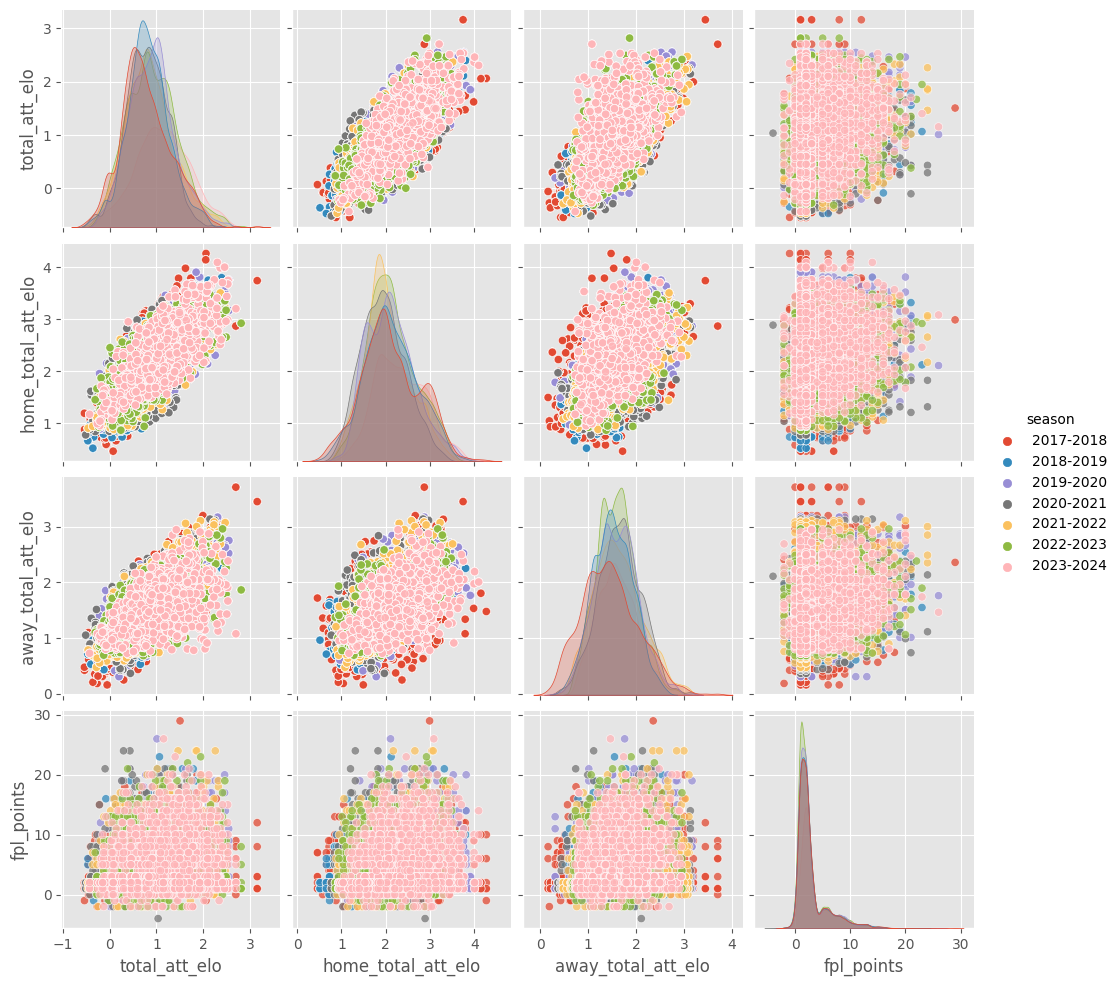

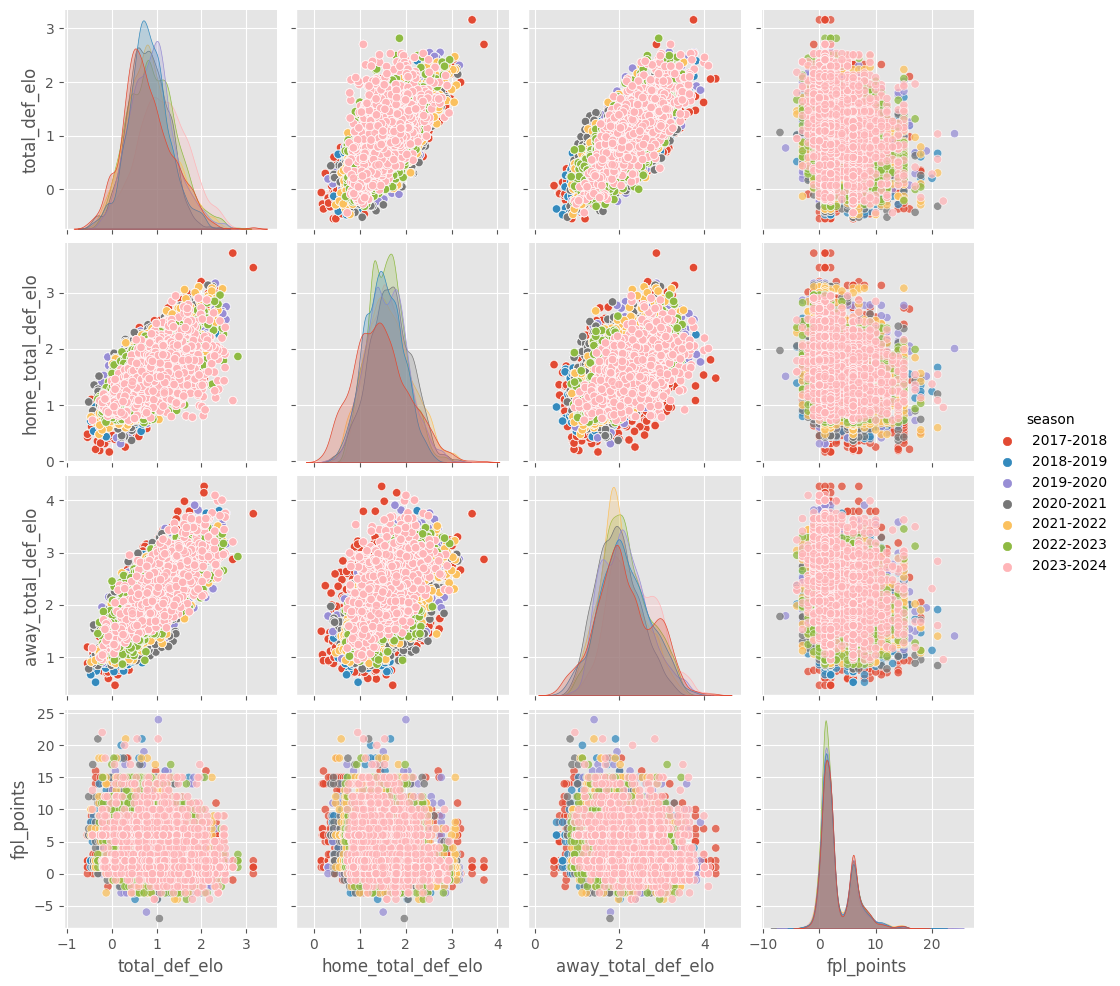

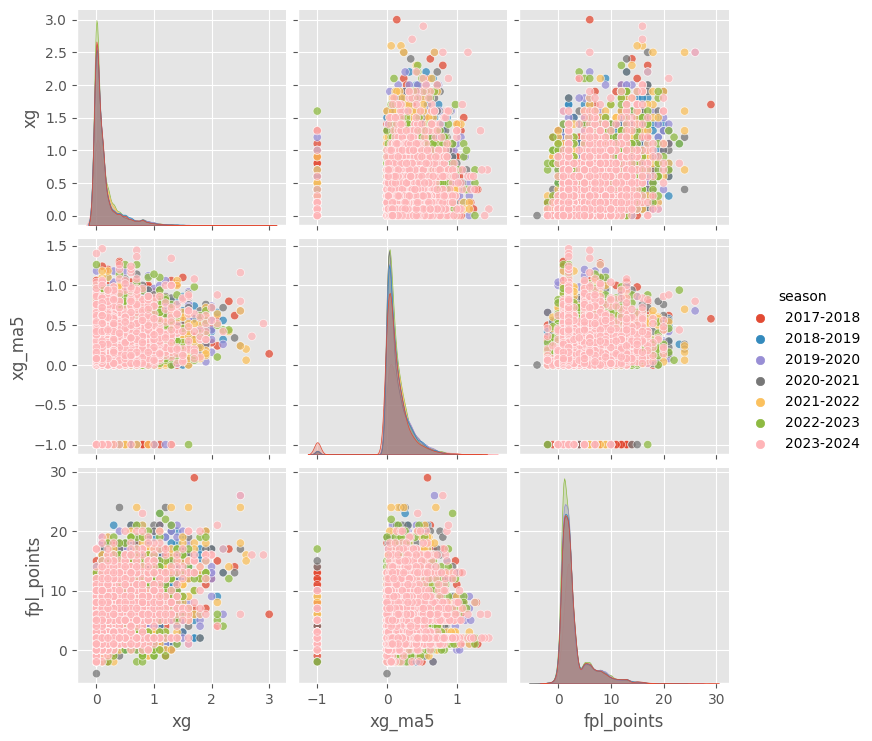

In [21]:
def plot_pairplot(data, columns):
    sns.pairplot(
        data, 
        vars=columns,
        hue="season",
        plot_kws={'alpha': 0.75})
    plt.show()
    
    
plot_pairplot(processed_data.query("type=='att'"), 
              columns=["total_att_elo", "home_total_att_elo", "away_total_att_elo", "fpl_points"])
plot_pairplot(processed_data.query("type=='def'"), 
              columns=["total_def_elo", "home_total_def_elo", "away_total_def_elo", "fpl_points"])
plot_pairplot(processed_data.query("type=='att'"), 
              columns=["xg", "xg_ma5", "fpl_points"])

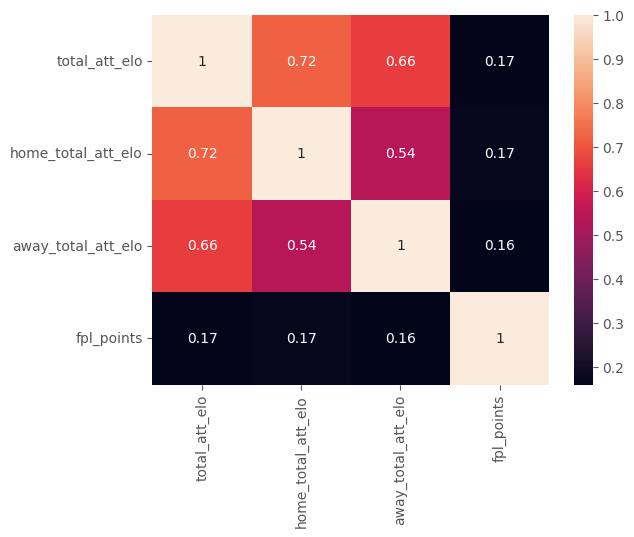

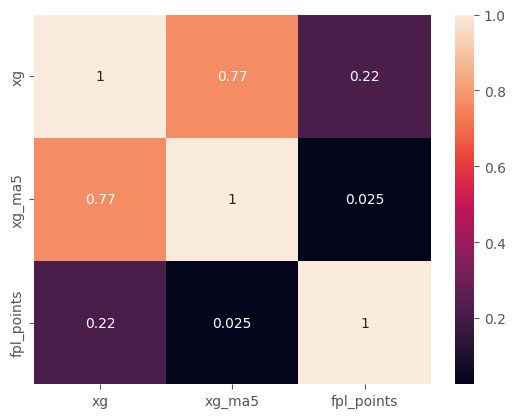

In [22]:
sns.heatmap(processed_data[["total_att_elo", "home_total_att_elo", "away_total_att_elo", "fpl_points"]].corr(), annot=True)
plt.show()

sns.heatmap(processed_data[["xg", "xg_ma5", "fpl_points"]].corr(), annot=True)
plt.show()

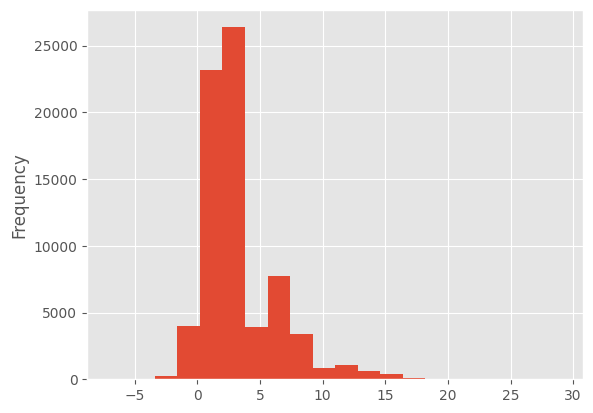

In [23]:
processed_data["fpl_points"].plot(kind='hist', bins=20)
plt.show()

## Model creation

In [51]:
def encode_features(X, categorical_features, numerical_features, encoder):
    X_cat = X[categorical_features]
    X_num = X[numerical_features]

    X_encoded = np.hstack([
        encoder.transform(X_cat).toarray(),
        X_num
    ])
    return X_encoded

In [ ]:
numerical_features = ['ROUND', 'POSS', 'DAYS_TILL_NEXT', 'DAYS_SINCE_LAST', 'ATT_TOTAL', 'HOME_ATT_TOTAL', 'AWAY_ATT_TOTAL'] 
# 'DEF_TOTAL', 'HOME_DEF_TOTAL', 'AWAY_DEF_TOTAL', 'DATE', 'XGA', ]
categorical_features = ['VENUE', 'TEAM', 'OPPONENT']
target = "XG"

train_val_data = processed_data[processed_data['SEASON'] < "2021-2022"]
X_train_val = train_val_data[numerical_features+categorical_features]
y_train_val = train_val_data[target]

holdout_data = processed_data[processed_data['SEASON'] >= "2021-2022"]
X_holdout  = holdout_data[numerical_features+categorical_features]
y_holdout  = holdout_data[target]

In [62]:
groups = train_val_data["SEASON"]
n_splits = groups.nunique()
print(f"{groups.unique() = }")
group_kfold = GroupKFold(n_splits=n_splits)

X_train_val_cat = X_train_val[categorical_features]
categories = [np.append(X_train_val_cat[col].unique(), 'Unknown') for col in X_train_val_cat.columns]
encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', categories=categories, min_frequency=1)
encoder.fit(X_train_val_cat)
encoded_cat_cols = encoder.get_feature_names_out(input_features=categorical_features)

model = XGBRegressor(
    base_score=0.5,
    n_estimators=1000,
    early_stopping_rounds=50,
    objective ='reg:squarederror', 
    learning_rate=0.01,
    eval_metric='mae', 
    seed=42
    )

cross_val_scores = []
for train_index, val_index in group_kfold.split(X_train_val, y_train_val, groups):

    # Remove outliers
    X_train, y_train = X_train_val.iloc[train_index], y_train_val.iloc[train_index]
    outlier = y_train > 4
    X_train, y_train = X_train.loc[~outlier], y_train.loc[~outlier]

    X_train_encoded = encode_features(X_train, categorical_features, numerical_features, encoder)    
    X_val_encoded = encode_features(X_train_val.iloc[val_index], categorical_features, numerical_features, encoder)
    y_val = y_train_val.iloc[val_index]

    model.fit(
        X_train_encoded, y_train,
        eval_set=[(X_train_encoded, y_train), (X_val_encoded, y_val)],
        verbose=100
        )

    val_predictions = model.predict(X_val_encoded)
    val_accuracy = mean_squared_error(y_val, val_predictions)
    cross_val_scores.append(val_accuracy)


avg_cv_accuracy = sum(cross_val_scores) / n_splits
print(f'Average cross-validation accuracy: {avg_cv_accuracy}')
print(cross_val_scores)

groups.unique() = array(['2017-2018', '2018-2019', '2019-2020', '2020-2021'], dtype=object)
[0]	validation_0-mae:0.84848	validation_1-mae:0.83666
[100]	validation_0-mae:0.51876	validation_1-mae:0.57969
[200]	validation_0-mae:0.45042	validation_1-mae:0.55539
[293]	validation_0-mae:0.42850	validation_1-mae:0.55634
[0]	validation_0-mae:0.82986	validation_1-mae:0.90709
[100]	validation_0-mae:0.51563	validation_1-mae:0.62025
[200]	validation_0-mae:0.45334	validation_1-mae:0.58159
[296]	validation_0-mae:0.43136	validation_1-mae:0.57992
[0]	validation_0-mae:0.83460	validation_1-mae:0.88303
[100]	validation_0-mae:0.51894	validation_1-mae:0.58828
[200]	validation_0-mae:0.45594	validation_1-mae:0.54911
[266]	validation_0-mae:0.43895	validation_1-mae:0.54918
[0]	validation_0-mae:0.86094	validation_1-mae:0.79907
[100]	validation_0-mae:0.52959	validation_1-mae:0.53274
[198]	validation_0-mae:0.46486	validation_1-mae:0.52584
Average cross-validation accuracy: 0.5182467767576279
[0.5210533796878895, 0

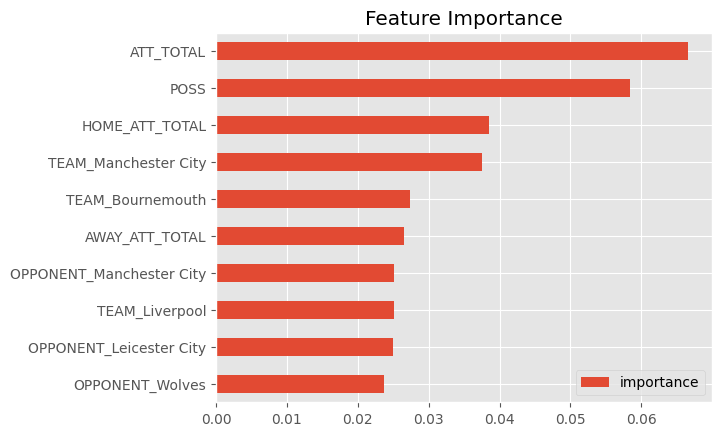

In [63]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=encoded_cat_cols.tolist()+numerical_features,
             columns=['importance'])
fi = fi.sort_values(by='importance', ascending=False).head(10)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

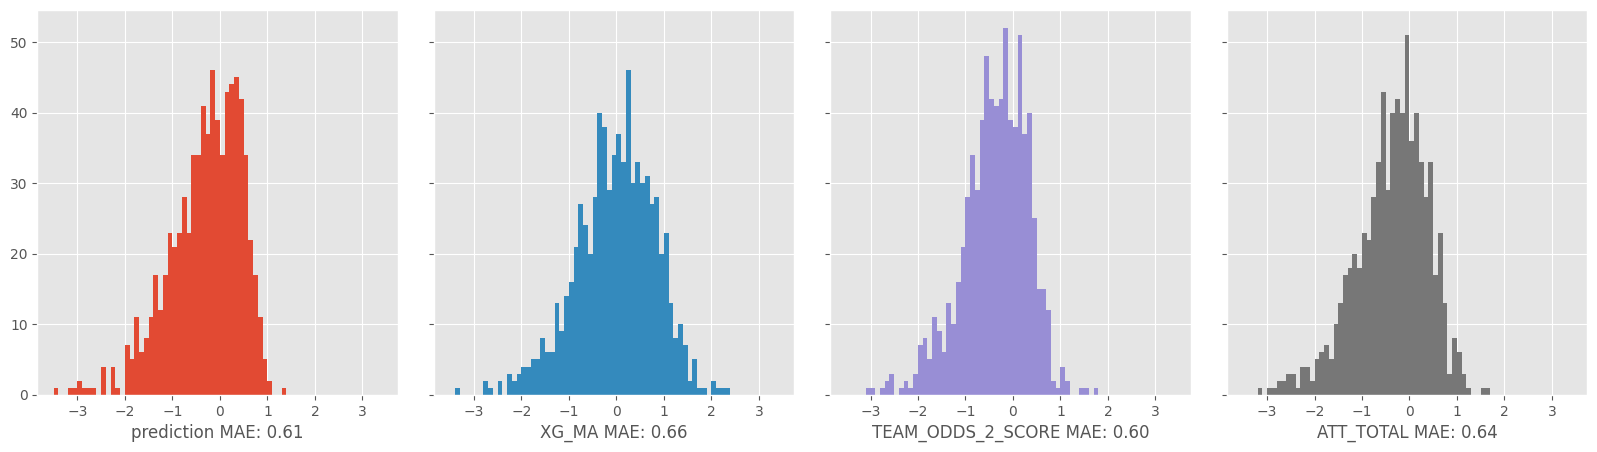

In [64]:
X_holdout_encoded = encode_features(X_holdout, categorical_features, numerical_features, encoder)
holdout_predictions = model.predict(X_holdout_encoded)


baseline_columns = ['XG_MA', "TEAM_ODDS_2_SCORE", 'ATT_TOTAL']
output_cols = list(set(["index"]+numerical_features+categorical_features+[target]+baseline_columns))
output_df = holdout_data[output_cols].copy()
eval_cols = ["prediction"]+baseline_columns
output_df["prediction"] = holdout_predictions

fig, axes = plt.subplots(nrows=1, ncols=len(eval_cols), figsize=(20, 5), sharey=True)

for i, col in enumerate(eval_cols):
    output_df[f"{col}_error"] = output_df[col] - output_df[target]
    output_df[f"{col}_error"].hist(ax=axes[i], bins=np.arange(-3.5, 3.5, 0.1), color=color_pal[i])
    mae = output_df[f"{col}_error"].abs().mean()
    axes[i].set_xlabel(f"{col} MAE: {mae:.2f}")
output_df.head()
plt.subplots_adjust(wspace=0.1)
plt.show()